# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [ ]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

Archive:  processed-celeba-small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.io import read_image
import os

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [ToTensor(),
                 Resize(size),
                 Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        self.img_names = [file for file in os.listdir(self.directory) if file.endswith(extension)]
        

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.img_names)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        img_path = os.path.join(self.directory, self.img_names[index])
        #print(img_path)
        image = Image.open(img_path)
        image = self.transforms(image)
        return image

In [5]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)));
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

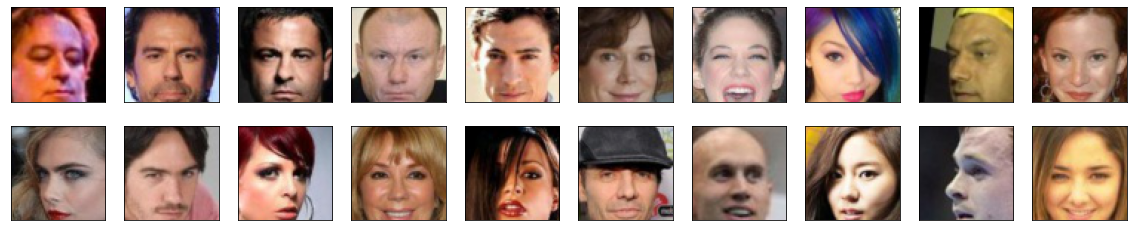

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8);

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4));
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[]);
    img = dataset[idx].numpy();
    img = np.transpose(img, (1, 2, 0));
    img = denormalize(img);
    ax.imshow(img);

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [7]:
from torch.nn import Module
from torch import nn

In [8]:
class ConvBlock(Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
       ####
        # IMPLEMENT HERE
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act_fn = nn.LeakyReLU(0.1)
       ####
      
    def forward(self, x: torch.Tensor) -> torch.Tensor:
       ####
       # IMPLEMENT HERE
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        x = self.act_fn(x)
       ####
        return x

In [9]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        conv_dim = 64
        self.conv1 = ConvBlock(3, conv_dim * 2, 4, False)
        self.conv2 = ConvBlock(conv_dim * 2, conv_dim * 4, 4)
        self.conv3 = ConvBlock(conv_dim * 4, conv_dim * 8, 4)
        self.fc = nn.Linear(6 * 6 * 512, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = x.view(-1,1,1,1)
        return x

In [10]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [11]:
class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer

    - batch_norm: whether to use batch norm or not
    """
    def __init__(self,
                in_channels: int,
                out_channels: int,
                kernel_size: int,
                stride: int,
                padding: int,
                batch_norm: bool = True):
        ####
        # IMPLEMENT HERE
        super(DeconvBlock, self).__init__()
        self.trans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        ####
      
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ####
        # IMPLEMENT HERE
        x = self.trans(x)
        if self.bn:
            x = self.bn(x)
        x = self.activation(x)
        ####
        return x

In [12]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        conv_dim = 64
        # TODO: instantiate the different layers
        self.transpose1 = DeconvBlock(latent_dim, conv_dim * 16, 4, 2, 0)
        self.transpose2 = DeconvBlock(conv_dim * 16, conv_dim * 8, 4, 2, 1)
        self.transpose3 = DeconvBlock(conv_dim * 8, conv_dim * 4, 4, 2, 1)
        self.transpose4 = DeconvBlock(conv_dim * 4, conv_dim * 8, 4, 2, 1, 1)
        self.transpose5 = DeconvBlock(conv_dim * 8, 3, 4, 2, 1, False)
        self.last_activation = nn.Tanh()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.transpose1(x)
        x = self.transpose2(x)
        x = self.transpose3(x)
        x = self.transpose4(x)
        x = self.transpose5(x)
        x = self.last_activation(x)
        return x

In [13]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [14]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    
    # params
    lr = 0.0002
    beta1 = 0.3
    beta2 = 0.8

    # Create optimizers for the discriminator and generator
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr, (beta1, beta2))
    g_optimizer = torch.optim.Adam(generator.parameters(), lr, (beta1, beta2))
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [15]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    #if train_on_gpu:
    labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    #if train_on_gpu:
    labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [16]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss 
    
    g_loss = real_loss(fake_logits)

    return g_loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [17]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss 

    d_real_loss = real_loss(real_logits, smooth=True)

    d_fake_loss = fake_loss(fake_logits)
    d_loss = d_real_loss + d_fake_loss

    return d_loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [18]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    alpha = torch.rand(real_samples.shape).cuda()
    
    x_hat = alpha * real_samples + (1 - alpha) * fake_samples
    
    x_dash = x_hat.clone().requires_grad_(True)
    pred = discriminator(x_dash)
    grad = torch.autograd.grad(pred,
                              x_dash,
                              grad_outputs = torch.ones_like(pred),
                              create_graph = True)[0]
    norm = torch.norm(grad.view(-1), 2)
    gp = ((norm - 1)**2).mean()

    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [19]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    
    rand_z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    rand_z = torch.from_numpy(rand_z).float()

    #if train_on_gpu:
    rand_z = rand_z.cuda()

    g_optimizer.zero_grad()
    fake_images = generator(rand_z)
    g_loss = generator_loss(discriminator(fake_images))

    g_loss.backward()
    g_optimizer.step()
    
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    #if train_on_gpu:
    real_images = real_images.cuda()

    d_optimizer.zero_grad()
    D_out = discriminator(real_images)
    d_real_loss = real_loss(discriminator(real_images), smooth=True)

    rand_z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    rand_z = torch.from_numpy(rand_z).float()

    #if train_on_gpu:
    rand_z = rand_z.cuda()

    fake_images = generator(rand_z)
    d_fake_loss = fake_loss(discriminator(fake_images))
    d_loss = d_real_loss + d_fake_loss

    d_loss.backward()
    d_optimizer.step()


    gp = gradient_penalty(discriminator, real_images, fake_images)

    
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [20]:
from datetime import datetime

In [21]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 25

# number of images in each batch
batch_size = 64

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [23]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2025-02-28 08:40:10 | Epoch [1/25] | Batch 0/509 | d_loss: 1.4575 | g_loss: 2.6972
2025-02-28 08:40:32 | Epoch [1/25] | Batch 50/509 | d_loss: 0.3737 | g_loss: 8.4158
2025-02-28 08:40:56 | Epoch [1/25] | Batch 100/509 | d_loss: 0.5223 | g_loss: 10.9258
2025-02-28 08:41:20 | Epoch [1/25] | Batch 150/509 | d_loss: 1.2346 | g_loss: 1.6302
2025-02-28 08:41:44 | Epoch [1/25] | Batch 200/509 | d_loss: 1.3667 | g_loss: 1.3240
2025-02-28 08:42:08 | Epoch [1/25] | Batch 250/509 | d_loss: 1.4289 | g_loss: 3.1224
2025-02-28 08:42:32 | Epoch [1/25] | Batch 300/509 | d_loss: 1.3584 | g_loss: 2.9245
2025-02-28 08:42:56 | Epoch [1/25] | Batch 350/509 | d_loss: 1.0920 | g_loss: 1.5459
2025-02-28 08:43:20 | Epoch [1/25] | Batch 400/509 | d_loss: 1.1570 | g_loss: 2.7616
2025-02-28 08:43:44 | Epoch [1/25] | Batch 450/509 | d_loss: 1.1686 | g_loss: 1.1560
2025-02-28 08:44:08 | Epoch [1/25] | Batch 500/509 | d_loss: 1.8394 | g_loss: 2.8856


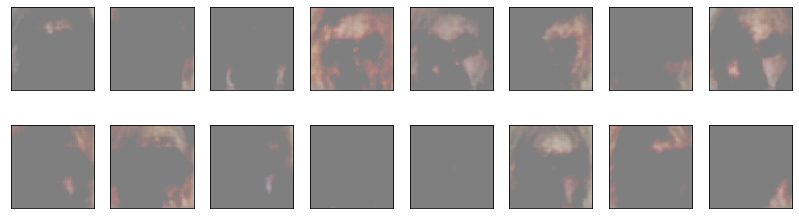

2025-02-28 08:44:15 | Epoch [2/25] | Batch 0/509 | d_loss: 1.2259 | g_loss: 1.5673
2025-02-28 08:44:39 | Epoch [2/25] | Batch 50/509 | d_loss: 1.0169 | g_loss: 2.5994
2025-02-28 08:45:04 | Epoch [2/25] | Batch 100/509 | d_loss: 1.2577 | g_loss: 2.9633
2025-02-28 08:45:28 | Epoch [2/25] | Batch 150/509 | d_loss: 1.2608 | g_loss: 1.6721
2025-02-28 08:45:52 | Epoch [2/25] | Batch 200/509 | d_loss: 1.0058 | g_loss: 1.9042
2025-02-28 08:46:17 | Epoch [2/25] | Batch 250/509 | d_loss: 1.3074 | g_loss: 2.9323
2025-02-28 08:46:41 | Epoch [2/25] | Batch 300/509 | d_loss: 1.5780 | g_loss: 3.3707
2025-02-28 08:47:05 | Epoch [2/25] | Batch 350/509 | d_loss: 1.3289 | g_loss: 0.9905
2025-02-28 08:47:29 | Epoch [2/25] | Batch 400/509 | d_loss: 0.9232 | g_loss: 1.9380
2025-02-28 08:47:54 | Epoch [2/25] | Batch 450/509 | d_loss: 1.3433 | g_loss: 3.5084
2025-02-28 08:48:18 | Epoch [2/25] | Batch 500/509 | d_loss: 1.1751 | g_loss: 2.7090


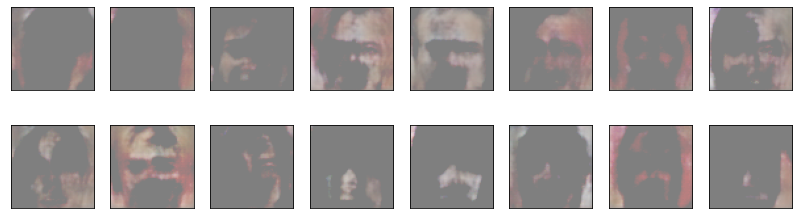

2025-02-28 08:48:26 | Epoch [3/25] | Batch 0/509 | d_loss: 0.9628 | g_loss: 1.5482
2025-02-28 08:48:50 | Epoch [3/25] | Batch 50/509 | d_loss: 0.9587 | g_loss: 2.5270
2025-02-28 08:49:15 | Epoch [3/25] | Batch 100/509 | d_loss: 1.0642 | g_loss: 2.6363
2025-02-28 08:49:40 | Epoch [3/25] | Batch 150/509 | d_loss: 0.7446 | g_loss: 2.1750
2025-02-28 08:50:04 | Epoch [3/25] | Batch 200/509 | d_loss: 0.8614 | g_loss: 2.2791
2025-02-28 08:50:29 | Epoch [3/25] | Batch 250/509 | d_loss: 0.8282 | g_loss: 2.8940
2025-02-28 08:50:53 | Epoch [3/25] | Batch 300/509 | d_loss: 1.4800 | g_loss: 1.3414
2025-02-28 08:51:18 | Epoch [3/25] | Batch 350/509 | d_loss: 1.0065 | g_loss: 1.9767
2025-02-28 08:51:42 | Epoch [3/25] | Batch 400/509 | d_loss: 1.1325 | g_loss: 3.3215
2025-02-28 08:52:07 | Epoch [3/25] | Batch 450/509 | d_loss: 1.0576 | g_loss: 4.3039
2025-02-28 08:52:31 | Epoch [3/25] | Batch 500/509 | d_loss: 1.0762 | g_loss: 4.0109


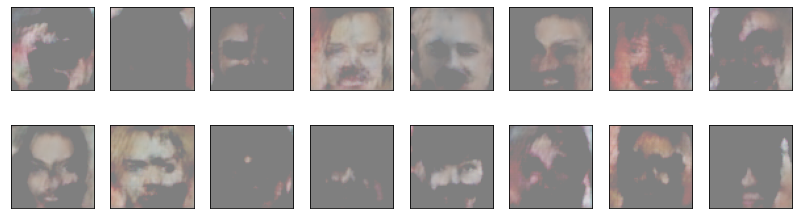

2025-02-28 08:52:40 | Epoch [4/25] | Batch 0/509 | d_loss: 0.9033 | g_loss: 1.8659
2025-02-28 08:53:04 | Epoch [4/25] | Batch 50/509 | d_loss: 1.0274 | g_loss: 1.4372
2025-02-28 08:53:29 | Epoch [4/25] | Batch 100/509 | d_loss: 1.0520 | g_loss: 3.5837
2025-02-28 08:53:53 | Epoch [4/25] | Batch 150/509 | d_loss: 0.6728 | g_loss: 1.8710
2025-02-28 08:54:17 | Epoch [4/25] | Batch 200/509 | d_loss: 1.7640 | g_loss: 2.1863
2025-02-28 08:54:41 | Epoch [4/25] | Batch 250/509 | d_loss: 0.8057 | g_loss: 2.4046
2025-02-28 08:55:05 | Epoch [4/25] | Batch 300/509 | d_loss: 1.0041 | g_loss: 2.1778
2025-02-28 08:55:30 | Epoch [4/25] | Batch 350/509 | d_loss: 1.0595 | g_loss: 3.5572
2025-02-28 08:55:55 | Epoch [4/25] | Batch 400/509 | d_loss: 0.6802 | g_loss: 2.6855
2025-02-28 08:56:19 | Epoch [4/25] | Batch 450/509 | d_loss: 0.8785 | g_loss: 2.2389
2025-02-28 08:56:44 | Epoch [4/25] | Batch 500/509 | d_loss: 0.8571 | g_loss: 2.7803


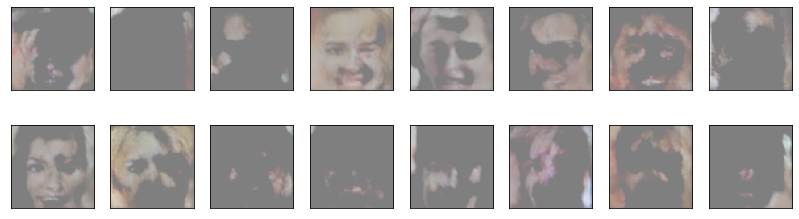

2025-02-28 08:56:52 | Epoch [5/25] | Batch 0/509 | d_loss: 0.8287 | g_loss: 2.0935
2025-02-28 08:57:17 | Epoch [5/25] | Batch 50/509 | d_loss: 0.5944 | g_loss: 2.7300
2025-02-28 08:57:41 | Epoch [5/25] | Batch 100/509 | d_loss: 0.8576 | g_loss: 2.6749
2025-02-28 08:58:06 | Epoch [5/25] | Batch 150/509 | d_loss: 0.6071 | g_loss: 2.3530
2025-02-28 08:58:30 | Epoch [5/25] | Batch 200/509 | d_loss: 0.6213 | g_loss: 1.7073
2025-02-28 08:58:54 | Epoch [5/25] | Batch 250/509 | d_loss: 0.7055 | g_loss: 2.8135
2025-02-28 08:59:18 | Epoch [5/25] | Batch 300/509 | d_loss: 1.2301 | g_loss: 1.7536
2025-02-28 08:59:43 | Epoch [5/25] | Batch 350/509 | d_loss: 0.7382 | g_loss: 2.8089
2025-02-28 09:00:07 | Epoch [5/25] | Batch 400/509 | d_loss: 0.8823 | g_loss: 4.0186
2025-02-28 09:00:32 | Epoch [5/25] | Batch 450/509 | d_loss: 0.6785 | g_loss: 2.5494
2025-02-28 09:00:56 | Epoch [5/25] | Batch 500/509 | d_loss: 0.7299 | g_loss: 2.7429


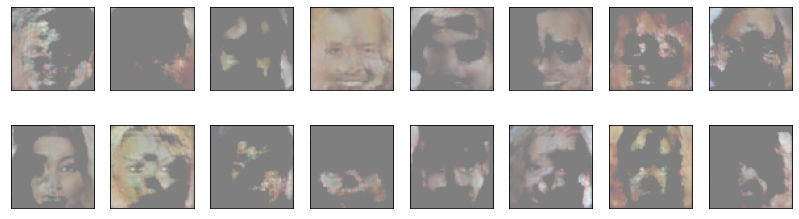

2025-02-28 09:01:04 | Epoch [6/25] | Batch 0/509 | d_loss: 0.7108 | g_loss: 2.8745
2025-02-28 09:01:29 | Epoch [6/25] | Batch 50/509 | d_loss: 0.8391 | g_loss: 4.6529
2025-02-28 09:01:53 | Epoch [6/25] | Batch 100/509 | d_loss: 1.2123 | g_loss: 1.7386
2025-02-28 09:02:18 | Epoch [6/25] | Batch 150/509 | d_loss: 0.9059 | g_loss: 3.1016
2025-02-28 09:02:42 | Epoch [6/25] | Batch 200/509 | d_loss: 0.6660 | g_loss: 2.7699
2025-02-28 09:03:07 | Epoch [6/25] | Batch 250/509 | d_loss: 1.3109 | g_loss: 3.7473
2025-02-28 09:03:31 | Epoch [6/25] | Batch 300/509 | d_loss: 0.6100 | g_loss: 3.3998
2025-02-28 09:03:56 | Epoch [6/25] | Batch 350/509 | d_loss: 0.9260 | g_loss: 1.5747
2025-02-28 09:04:20 | Epoch [6/25] | Batch 400/509 | d_loss: 1.6200 | g_loss: 1.5208
2025-02-28 09:04:45 | Epoch [6/25] | Batch 450/509 | d_loss: 0.9977 | g_loss: 4.5515
2025-02-28 09:05:09 | Epoch [6/25] | Batch 500/509 | d_loss: 1.0294 | g_loss: 1.4956


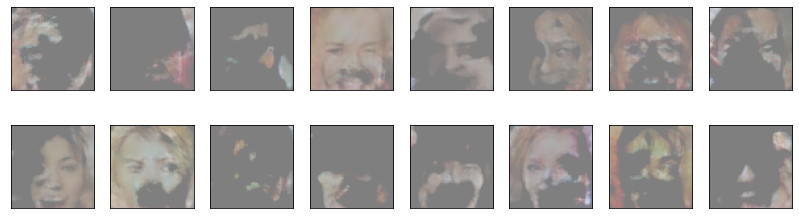

2025-02-28 09:05:17 | Epoch [7/25] | Batch 0/509 | d_loss: 0.7761 | g_loss: 2.6640
2025-02-28 09:05:41 | Epoch [7/25] | Batch 50/509 | d_loss: 0.7660 | g_loss: 3.1504
2025-02-28 09:06:05 | Epoch [7/25] | Batch 100/509 | d_loss: 0.7411 | g_loss: 2.3734
2025-02-28 09:06:30 | Epoch [7/25] | Batch 150/509 | d_loss: 1.7778 | g_loss: 1.4067
2025-02-28 09:06:54 | Epoch [7/25] | Batch 200/509 | d_loss: 0.9247 | g_loss: 3.4687
2025-02-28 09:07:18 | Epoch [7/25] | Batch 250/509 | d_loss: 0.8017 | g_loss: 3.4196
2025-02-28 09:07:42 | Epoch [7/25] | Batch 300/509 | d_loss: 0.6292 | g_loss: 3.1340
2025-02-28 09:08:06 | Epoch [7/25] | Batch 350/509 | d_loss: 1.0072 | g_loss: 1.1102
2025-02-28 09:08:30 | Epoch [7/25] | Batch 400/509 | d_loss: 0.9664 | g_loss: 3.8386
2025-02-28 09:08:55 | Epoch [7/25] | Batch 450/509 | d_loss: 0.9044 | g_loss: 3.3427
2025-02-28 09:09:19 | Epoch [7/25] | Batch 500/509 | d_loss: 0.8453 | g_loss: 3.2802


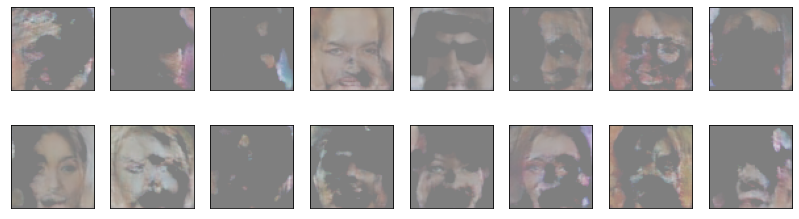

2025-02-28 09:09:28 | Epoch [8/25] | Batch 0/509 | d_loss: 1.2489 | g_loss: 1.6091
2025-02-28 09:09:52 | Epoch [8/25] | Batch 50/509 | d_loss: 0.9662 | g_loss: 1.4929
2025-02-28 09:10:17 | Epoch [8/25] | Batch 100/509 | d_loss: 0.7994 | g_loss: 3.4934
2025-02-28 09:10:41 | Epoch [8/25] | Batch 150/509 | d_loss: 0.8101 | g_loss: 2.8092
2025-02-28 09:11:05 | Epoch [8/25] | Batch 200/509 | d_loss: 0.8320 | g_loss: 1.4940
2025-02-28 09:11:29 | Epoch [8/25] | Batch 250/509 | d_loss: 0.6922 | g_loss: 1.5618
2025-02-28 09:11:53 | Epoch [8/25] | Batch 300/509 | d_loss: 0.9036 | g_loss: 2.7142
2025-02-28 09:12:17 | Epoch [8/25] | Batch 350/509 | d_loss: 0.7997 | g_loss: 4.1789
2025-02-28 09:12:41 | Epoch [8/25] | Batch 400/509 | d_loss: 0.6379 | g_loss: 3.1020
2025-02-28 09:13:05 | Epoch [8/25] | Batch 450/509 | d_loss: 0.9493 | g_loss: 1.8954
2025-02-28 09:13:29 | Epoch [8/25] | Batch 500/509 | d_loss: 0.7554 | g_loss: 1.6060


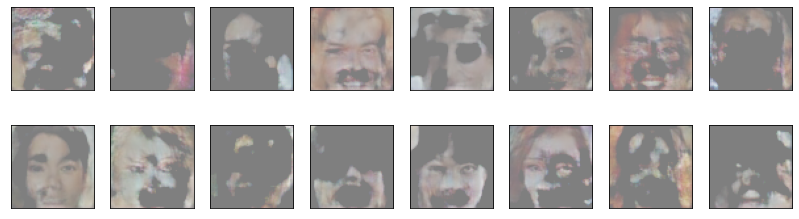

2025-02-28 09:13:38 | Epoch [9/25] | Batch 0/509 | d_loss: 0.8950 | g_loss: 3.9196
2025-02-28 09:14:02 | Epoch [9/25] | Batch 50/509 | d_loss: 0.9452 | g_loss: 2.2770
2025-02-28 09:14:26 | Epoch [9/25] | Batch 100/509 | d_loss: 1.8449 | g_loss: 1.6736
2025-02-28 09:14:51 | Epoch [9/25] | Batch 150/509 | d_loss: 0.7811 | g_loss: 2.4369
2025-02-28 09:15:15 | Epoch [9/25] | Batch 200/509 | d_loss: 0.6766 | g_loss: 3.8728
2025-02-28 09:15:39 | Epoch [9/25] | Batch 250/509 | d_loss: 1.1124 | g_loss: 1.7214
2025-02-28 09:16:04 | Epoch [9/25] | Batch 300/509 | d_loss: 0.8484 | g_loss: 2.7942
2025-02-28 09:16:28 | Epoch [9/25] | Batch 350/509 | d_loss: 1.2348 | g_loss: 1.9127
2025-02-28 09:16:52 | Epoch [9/25] | Batch 400/509 | d_loss: 0.7460 | g_loss: 2.5555
2025-02-28 09:17:16 | Epoch [9/25] | Batch 450/509 | d_loss: 1.0853 | g_loss: 1.6622
2025-02-28 09:17:41 | Epoch [9/25] | Batch 500/509 | d_loss: 1.2082 | g_loss: 0.8652


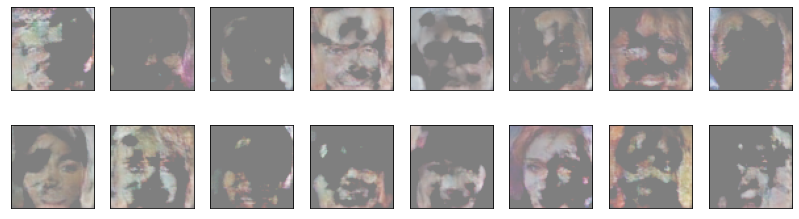

2025-02-28 09:17:48 | Epoch [10/25] | Batch 0/509 | d_loss: 0.6657 | g_loss: 2.1929
2025-02-28 09:18:13 | Epoch [10/25] | Batch 50/509 | d_loss: 0.7881 | g_loss: 2.7655
2025-02-28 09:18:37 | Epoch [10/25] | Batch 100/509 | d_loss: 0.8857 | g_loss: 1.2644
2025-02-28 09:19:01 | Epoch [10/25] | Batch 150/509 | d_loss: 1.4627 | g_loss: 5.4376
2025-02-28 09:19:25 | Epoch [10/25] | Batch 200/509 | d_loss: 0.7062 | g_loss: 4.1143
2025-02-28 09:19:49 | Epoch [10/25] | Batch 250/509 | d_loss: 1.1759 | g_loss: 0.9937
2025-02-28 09:20:14 | Epoch [10/25] | Batch 300/509 | d_loss: 0.6640 | g_loss: 1.7520
2025-02-28 09:20:38 | Epoch [10/25] | Batch 350/509 | d_loss: 1.0243 | g_loss: 1.1083
2025-02-28 09:21:02 | Epoch [10/25] | Batch 400/509 | d_loss: 0.6144 | g_loss: 2.4690
2025-02-28 09:21:27 | Epoch [10/25] | Batch 450/509 | d_loss: 1.3595 | g_loss: 4.7412
2025-02-28 09:21:51 | Epoch [10/25] | Batch 500/509 | d_loss: 0.8225 | g_loss: 3.7462


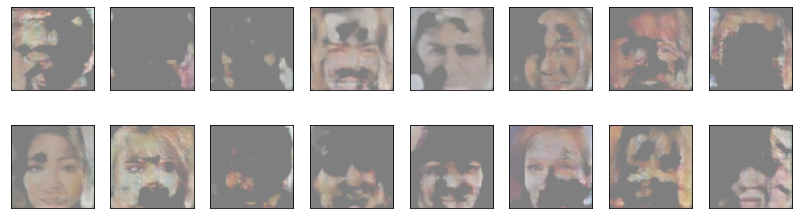

2025-02-28 09:21:59 | Epoch [11/25] | Batch 0/509 | d_loss: 0.5665 | g_loss: 2.9498
2025-02-28 09:22:23 | Epoch [11/25] | Batch 50/509 | d_loss: 0.9766 | g_loss: 3.7893
2025-02-28 09:22:48 | Epoch [11/25] | Batch 100/509 | d_loss: 0.6783 | g_loss: 3.2622
2025-02-28 09:23:12 | Epoch [11/25] | Batch 150/509 | d_loss: 0.6813 | g_loss: 2.7150
2025-02-28 09:23:36 | Epoch [11/25] | Batch 200/509 | d_loss: 0.7200 | g_loss: 2.7585
2025-02-28 09:24:00 | Epoch [11/25] | Batch 250/509 | d_loss: 0.9278 | g_loss: 2.0032
2025-02-28 09:24:23 | Epoch [11/25] | Batch 300/509 | d_loss: 1.1277 | g_loss: 1.4598
2025-02-28 09:24:47 | Epoch [11/25] | Batch 350/509 | d_loss: 0.6164 | g_loss: 2.2524
2025-02-28 09:25:12 | Epoch [11/25] | Batch 400/509 | d_loss: 1.2427 | g_loss: 1.7530
2025-02-28 09:25:36 | Epoch [11/25] | Batch 450/509 | d_loss: 0.7106 | g_loss: 2.3483
2025-02-28 09:26:00 | Epoch [11/25] | Batch 500/509 | d_loss: 1.0896 | g_loss: 4.3363


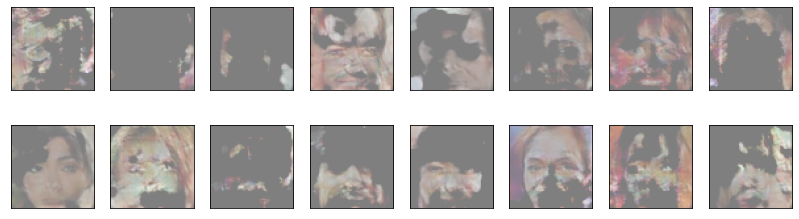

2025-02-28 09:26:07 | Epoch [12/25] | Batch 0/509 | d_loss: 0.6797 | g_loss: 1.8965
2025-02-28 09:26:31 | Epoch [12/25] | Batch 50/509 | d_loss: 0.7425 | g_loss: 1.6039
2025-02-28 09:26:55 | Epoch [12/25] | Batch 100/509 | d_loss: 0.7508 | g_loss: 2.2720
2025-02-28 09:27:19 | Epoch [12/25] | Batch 150/509 | d_loss: 0.6798 | g_loss: 1.5447
2025-02-28 09:27:43 | Epoch [12/25] | Batch 200/509 | d_loss: 0.8975 | g_loss: 3.8672
2025-02-28 09:28:06 | Epoch [12/25] | Batch 250/509 | d_loss: 0.8547 | g_loss: 1.2815
2025-02-28 09:28:30 | Epoch [12/25] | Batch 300/509 | d_loss: 0.5455 | g_loss: 3.3729
2025-02-28 09:28:54 | Epoch [12/25] | Batch 350/509 | d_loss: 0.8448 | g_loss: 1.4241
2025-02-28 09:29:18 | Epoch [12/25] | Batch 400/509 | d_loss: 0.6705 | g_loss: 3.4929
2025-02-28 09:29:42 | Epoch [12/25] | Batch 450/509 | d_loss: 0.7545 | g_loss: 3.0456
2025-02-28 09:30:06 | Epoch [12/25] | Batch 500/509 | d_loss: 0.8229 | g_loss: 1.7259


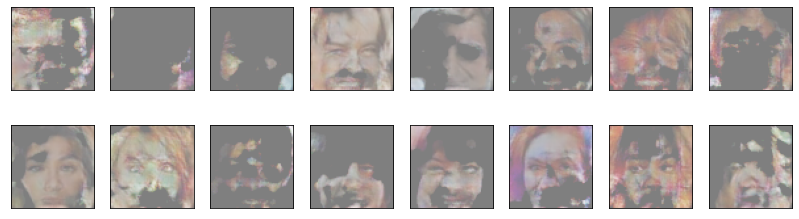

2025-02-28 09:30:13 | Epoch [13/25] | Batch 0/509 | d_loss: 0.6413 | g_loss: 2.0370
2025-02-28 09:30:37 | Epoch [13/25] | Batch 50/509 | d_loss: 1.0475 | g_loss: 3.7025
2025-02-28 09:31:01 | Epoch [13/25] | Batch 100/509 | d_loss: 0.9952 | g_loss: 1.6171
2025-02-28 09:31:25 | Epoch [13/25] | Batch 150/509 | d_loss: 0.7748 | g_loss: 4.2394
2025-02-28 09:31:49 | Epoch [13/25] | Batch 200/509 | d_loss: 0.8411 | g_loss: 1.9894
2025-02-28 09:32:12 | Epoch [13/25] | Batch 250/509 | d_loss: 1.2083 | g_loss: 1.1694
2025-02-28 09:32:36 | Epoch [13/25] | Batch 300/509 | d_loss: 0.8530 | g_loss: 1.9258
2025-02-28 09:33:00 | Epoch [13/25] | Batch 350/509 | d_loss: 0.6047 | g_loss: 2.2350
2025-02-28 09:33:24 | Epoch [13/25] | Batch 400/509 | d_loss: 0.9675 | g_loss: 1.4630
2025-02-28 09:33:48 | Epoch [13/25] | Batch 450/509 | d_loss: 1.2057 | g_loss: 1.5507
2025-02-28 09:34:12 | Epoch [13/25] | Batch 500/509 | d_loss: 0.5633 | g_loss: 3.4478


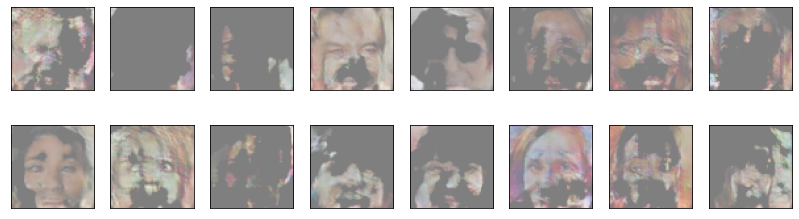

2025-02-28 09:34:20 | Epoch [14/25] | Batch 0/509 | d_loss: 0.9069 | g_loss: 1.2748
2025-02-28 09:34:44 | Epoch [14/25] | Batch 50/509 | d_loss: 0.8719 | g_loss: 1.4017
2025-02-28 09:35:08 | Epoch [14/25] | Batch 100/509 | d_loss: 0.8379 | g_loss: 2.9075
2025-02-28 09:35:32 | Epoch [14/25] | Batch 150/509 | d_loss: 0.9084 | g_loss: 5.3058
2025-02-28 09:35:55 | Epoch [14/25] | Batch 200/509 | d_loss: 0.8014 | g_loss: 1.2844
2025-02-28 09:36:19 | Epoch [14/25] | Batch 250/509 | d_loss: 0.8988 | g_loss: 4.7115
2025-02-28 09:36:43 | Epoch [14/25] | Batch 300/509 | d_loss: 0.9700 | g_loss: 2.1754
2025-02-28 09:37:07 | Epoch [14/25] | Batch 350/509 | d_loss: 0.8520 | g_loss: 2.6700
2025-02-28 09:37:31 | Epoch [14/25] | Batch 400/509 | d_loss: 0.9894 | g_loss: 1.8604
2025-02-28 09:37:55 | Epoch [14/25] | Batch 450/509 | d_loss: 1.1228 | g_loss: 4.8643
2025-02-28 09:38:19 | Epoch [14/25] | Batch 500/509 | d_loss: 1.2456 | g_loss: 4.1790


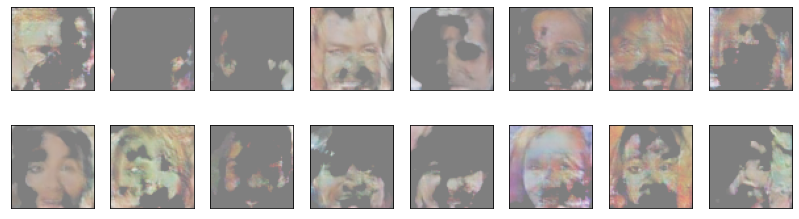

2025-02-28 09:38:27 | Epoch [15/25] | Batch 0/509 | d_loss: 1.8250 | g_loss: 1.2755
2025-02-28 09:38:51 | Epoch [15/25] | Batch 50/509 | d_loss: 0.9779 | g_loss: 4.2675
2025-02-28 09:39:15 | Epoch [15/25] | Batch 100/509 | d_loss: 0.8179 | g_loss: 5.3567
2025-02-28 09:39:39 | Epoch [15/25] | Batch 150/509 | d_loss: 0.7366 | g_loss: 2.5653
2025-02-28 09:40:02 | Epoch [15/25] | Batch 200/509 | d_loss: 1.6037 | g_loss: 4.8256
2025-02-28 09:40:26 | Epoch [15/25] | Batch 250/509 | d_loss: 1.1226 | g_loss: 4.1161
2025-02-28 09:40:50 | Epoch [15/25] | Batch 300/509 | d_loss: 0.7603 | g_loss: 1.3075
2025-02-28 09:41:14 | Epoch [15/25] | Batch 350/509 | d_loss: 0.9806 | g_loss: 1.8942
2025-02-28 09:41:38 | Epoch [15/25] | Batch 400/509 | d_loss: 0.6118 | g_loss: 3.3465
2025-02-28 09:42:02 | Epoch [15/25] | Batch 450/509 | d_loss: 0.6839 | g_loss: 1.5790
2025-02-28 09:42:26 | Epoch [15/25] | Batch 500/509 | d_loss: 0.8515 | g_loss: 1.6919


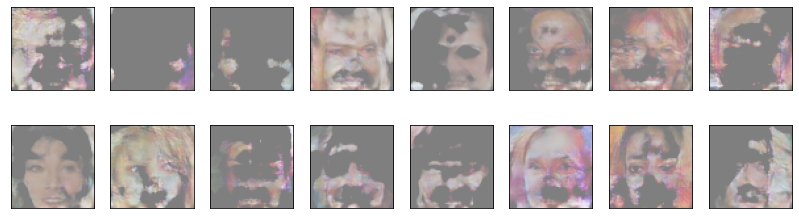

2025-02-28 09:42:33 | Epoch [16/25] | Batch 0/509 | d_loss: 1.2734 | g_loss: 0.4674
2025-02-28 09:42:57 | Epoch [16/25] | Batch 50/509 | d_loss: 1.1272 | g_loss: 4.1114
2025-02-28 09:43:21 | Epoch [16/25] | Batch 100/509 | d_loss: 1.0195 | g_loss: 1.6190
2025-02-28 09:43:45 | Epoch [16/25] | Batch 150/509 | d_loss: 1.0855 | g_loss: 1.7758
2025-02-28 09:44:09 | Epoch [16/25] | Batch 200/509 | d_loss: 0.7913 | g_loss: 1.7900
2025-02-28 09:44:32 | Epoch [16/25] | Batch 250/509 | d_loss: 0.6103 | g_loss: 2.2595
2025-02-28 09:44:56 | Epoch [16/25] | Batch 300/509 | d_loss: 0.9760 | g_loss: 1.6792
2025-02-28 09:45:20 | Epoch [16/25] | Batch 350/509 | d_loss: 0.8091 | g_loss: 3.5901
2025-02-28 09:45:44 | Epoch [16/25] | Batch 400/509 | d_loss: 0.6629 | g_loss: 2.9975
2025-02-28 09:46:08 | Epoch [16/25] | Batch 450/509 | d_loss: 0.6349 | g_loss: 3.1415
2025-02-28 09:46:32 | Epoch [16/25] | Batch 500/509 | d_loss: 0.7425 | g_loss: 2.7088


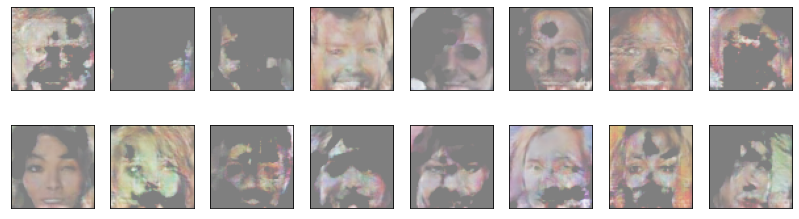

2025-02-28 09:46:40 | Epoch [17/25] | Batch 0/509 | d_loss: 0.8166 | g_loss: 2.6401
2025-02-28 09:47:03 | Epoch [17/25] | Batch 50/509 | d_loss: 0.7807 | g_loss: 1.0548
2025-02-28 09:47:27 | Epoch [17/25] | Batch 100/509 | d_loss: 0.7819 | g_loss: 4.0155
2025-02-28 09:47:51 | Epoch [17/25] | Batch 150/509 | d_loss: 0.7077 | g_loss: 1.8156
2025-02-28 09:48:15 | Epoch [17/25] | Batch 200/509 | d_loss: 0.6797 | g_loss: 2.2555
2025-02-28 09:48:39 | Epoch [17/25] | Batch 250/509 | d_loss: 1.0379 | g_loss: 4.2230
2025-02-28 09:49:03 | Epoch [17/25] | Batch 300/509 | d_loss: 0.9962 | g_loss: 1.7000
2025-02-28 09:49:27 | Epoch [17/25] | Batch 350/509 | d_loss: 0.7798 | g_loss: 1.9982
2025-02-28 09:49:51 | Epoch [17/25] | Batch 400/509 | d_loss: 1.5350 | g_loss: 0.9946
2025-02-28 09:50:14 | Epoch [17/25] | Batch 450/509 | d_loss: 1.4143 | g_loss: 4.1962
2025-02-28 09:50:38 | Epoch [17/25] | Batch 500/509 | d_loss: 0.8213 | g_loss: 1.5976


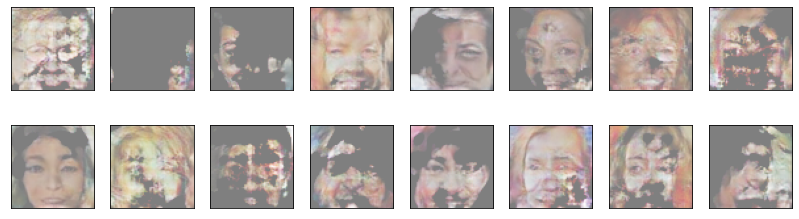

2025-02-28 09:50:46 | Epoch [18/25] | Batch 0/509 | d_loss: 1.5191 | g_loss: 3.7255
2025-02-28 09:51:10 | Epoch [18/25] | Batch 50/509 | d_loss: 1.0366 | g_loss: 1.2154
2025-02-28 09:51:34 | Epoch [18/25] | Batch 100/509 | d_loss: 0.6653 | g_loss: 2.2919
2025-02-28 09:51:58 | Epoch [18/25] | Batch 150/509 | d_loss: 0.8998 | g_loss: 2.1509
2025-02-28 09:52:21 | Epoch [18/25] | Batch 200/509 | d_loss: 1.4797 | g_loss: 0.6319
2025-02-28 09:52:45 | Epoch [18/25] | Batch 250/509 | d_loss: 0.6848 | g_loss: 2.7264
2025-02-28 09:53:09 | Epoch [18/25] | Batch 300/509 | d_loss: 0.6169 | g_loss: 4.1885
2025-02-28 09:53:33 | Epoch [18/25] | Batch 350/509 | d_loss: 0.6508 | g_loss: 3.4719
2025-02-28 09:53:57 | Epoch [18/25] | Batch 400/509 | d_loss: 0.6949 | g_loss: 2.7488
2025-02-28 09:54:21 | Epoch [18/25] | Batch 450/509 | d_loss: 0.9278 | g_loss: 2.2426
2025-02-28 09:54:44 | Epoch [18/25] | Batch 500/509 | d_loss: 0.6791 | g_loss: 3.1786


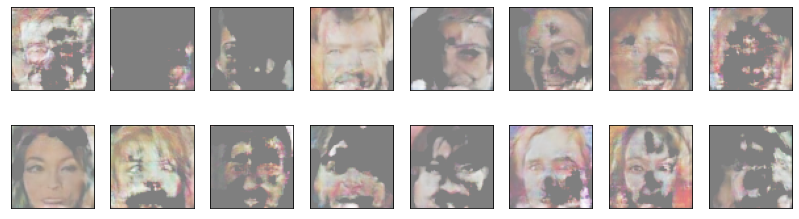

2025-02-28 09:54:53 | Epoch [19/25] | Batch 0/509 | d_loss: 0.7206 | g_loss: 2.7487
2025-02-28 09:55:17 | Epoch [19/25] | Batch 50/509 | d_loss: 0.9506 | g_loss: 3.9320
2025-02-28 09:55:40 | Epoch [19/25] | Batch 100/509 | d_loss: 1.0331 | g_loss: 1.7018
2025-02-28 09:56:04 | Epoch [19/25] | Batch 150/509 | d_loss: 0.6611 | g_loss: 1.4784
2025-02-28 09:56:28 | Epoch [19/25] | Batch 200/509 | d_loss: 1.4748 | g_loss: 4.9057
2025-02-28 09:56:52 | Epoch [19/25] | Batch 250/509 | d_loss: 0.8077 | g_loss: 1.9912
2025-02-28 09:57:16 | Epoch [19/25] | Batch 300/509 | d_loss: 1.3479 | g_loss: 1.7687
2025-02-28 09:57:39 | Epoch [19/25] | Batch 350/509 | d_loss: 0.7791 | g_loss: 1.7150
2025-02-28 09:58:03 | Epoch [19/25] | Batch 400/509 | d_loss: 0.6341 | g_loss: 2.3102
2025-02-28 09:58:27 | Epoch [19/25] | Batch 450/509 | d_loss: 1.0108 | g_loss: 1.7626
2025-02-28 09:58:51 | Epoch [19/25] | Batch 500/509 | d_loss: 1.1497 | g_loss: 3.0460


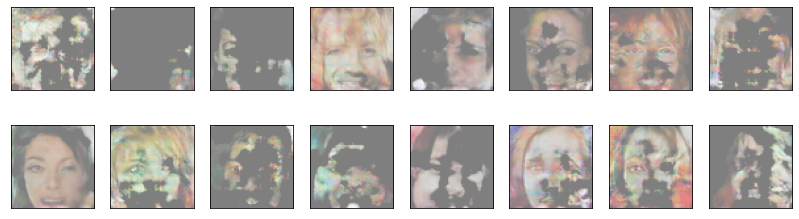

2025-02-28 09:58:58 | Epoch [20/25] | Batch 0/509 | d_loss: 0.8665 | g_loss: 3.1858
2025-02-28 09:59:22 | Epoch [20/25] | Batch 50/509 | d_loss: 0.9270 | g_loss: 3.7133
2025-02-28 09:59:46 | Epoch [20/25] | Batch 100/509 | d_loss: 0.8382 | g_loss: 1.2886
2025-02-28 10:00:10 | Epoch [20/25] | Batch 150/509 | d_loss: 0.8512 | g_loss: 1.9621
2025-02-28 10:00:34 | Epoch [20/25] | Batch 200/509 | d_loss: 0.7203 | g_loss: 2.0406
2025-02-28 10:00:58 | Epoch [20/25] | Batch 250/509 | d_loss: 0.6367 | g_loss: 2.4971
2025-02-28 10:01:21 | Epoch [20/25] | Batch 300/509 | d_loss: 0.8154 | g_loss: 3.4236
2025-02-28 10:01:45 | Epoch [20/25] | Batch 350/509 | d_loss: 0.9750 | g_loss: 4.0347
2025-02-28 10:02:09 | Epoch [20/25] | Batch 400/509 | d_loss: 0.5798 | g_loss: 2.8314
2025-02-28 10:02:33 | Epoch [20/25] | Batch 450/509 | d_loss: 0.7718 | g_loss: 2.9857
2025-02-28 10:02:56 | Epoch [20/25] | Batch 500/509 | d_loss: 0.8912 | g_loss: 1.3531


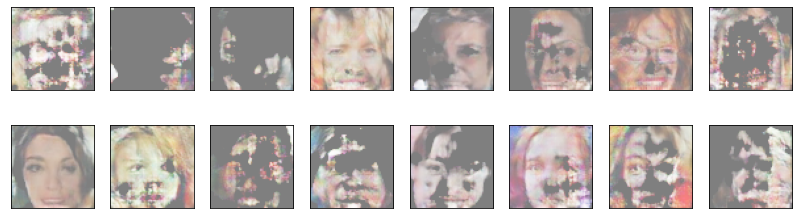

2025-02-28 10:03:04 | Epoch [21/25] | Batch 0/509 | d_loss: 0.5930 | g_loss: 3.0872
2025-02-28 10:03:28 | Epoch [21/25] | Batch 50/509 | d_loss: 0.5557 | g_loss: 3.0306
2025-02-28 10:03:51 | Epoch [21/25] | Batch 100/509 | d_loss: 1.2849 | g_loss: 1.1021
2025-02-28 10:04:15 | Epoch [21/25] | Batch 150/509 | d_loss: 1.1998 | g_loss: 1.4139
2025-02-28 10:04:39 | Epoch [21/25] | Batch 200/509 | d_loss: 1.0336 | g_loss: 1.8609
2025-02-28 10:05:03 | Epoch [21/25] | Batch 250/509 | d_loss: 0.7206 | g_loss: 3.0937
2025-02-28 10:05:26 | Epoch [21/25] | Batch 300/509 | d_loss: 1.2964 | g_loss: 4.6465
2025-02-28 10:05:50 | Epoch [21/25] | Batch 350/509 | d_loss: 0.9530 | g_loss: 1.0465
2025-02-28 10:06:14 | Epoch [21/25] | Batch 400/509 | d_loss: 0.8315 | g_loss: 1.7913
2025-02-28 10:06:38 | Epoch [21/25] | Batch 450/509 | d_loss: 0.6418 | g_loss: 3.1171
2025-02-28 10:07:02 | Epoch [21/25] | Batch 500/509 | d_loss: 1.4067 | g_loss: 1.4279


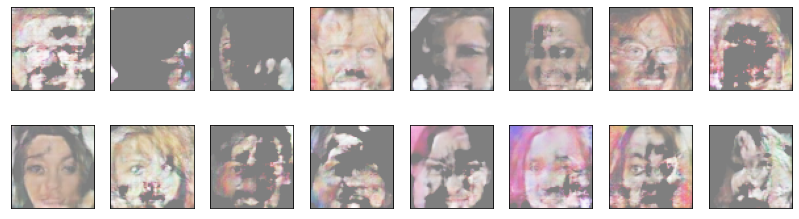

2025-02-28 10:07:10 | Epoch [22/25] | Batch 0/509 | d_loss: 1.0016 | g_loss: 3.5604
2025-02-28 10:07:34 | Epoch [22/25] | Batch 50/509 | d_loss: 0.6345 | g_loss: 4.0705
2025-02-28 10:07:58 | Epoch [22/25] | Batch 100/509 | d_loss: 0.9990 | g_loss: 3.4364
2025-02-28 10:08:22 | Epoch [22/25] | Batch 150/509 | d_loss: 0.9278 | g_loss: 2.5752
2025-02-28 10:08:46 | Epoch [22/25] | Batch 200/509 | d_loss: 0.8055 | g_loss: 1.5843
2025-02-28 10:09:09 | Epoch [22/25] | Batch 250/509 | d_loss: 0.8525 | g_loss: 1.0596
2025-02-28 10:09:33 | Epoch [22/25] | Batch 300/509 | d_loss: 0.5945 | g_loss: 3.8176
2025-02-28 10:09:57 | Epoch [22/25] | Batch 350/509 | d_loss: 0.9935 | g_loss: 0.9219
2025-02-28 10:10:21 | Epoch [22/25] | Batch 400/509 | d_loss: 0.9305 | g_loss: 3.7943
2025-02-28 10:10:45 | Epoch [22/25] | Batch 450/509 | d_loss: 0.6312 | g_loss: 2.0157
2025-02-28 10:11:09 | Epoch [22/25] | Batch 500/509 | d_loss: 0.6503 | g_loss: 3.1253


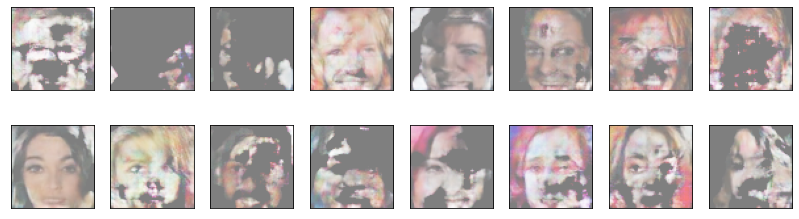

2025-02-28 10:11:17 | Epoch [23/25] | Batch 0/509 | d_loss: 0.6166 | g_loss: 2.4440
2025-02-28 10:11:41 | Epoch [23/25] | Batch 50/509 | d_loss: 0.8350 | g_loss: 3.3921
2025-02-28 10:12:05 | Epoch [23/25] | Batch 100/509 | d_loss: 0.7581 | g_loss: 4.4755
2025-02-28 10:12:29 | Epoch [23/25] | Batch 150/509 | d_loss: 0.7893 | g_loss: 2.2383
2025-02-28 10:12:53 | Epoch [23/25] | Batch 200/509 | d_loss: 0.7531 | g_loss: 3.3478
2025-02-28 10:13:16 | Epoch [23/25] | Batch 250/509 | d_loss: 0.5818 | g_loss: 3.8544
2025-02-28 10:13:40 | Epoch [23/25] | Batch 300/509 | d_loss: 0.6628 | g_loss: 1.3121
2025-02-28 10:14:04 | Epoch [23/25] | Batch 350/509 | d_loss: 2.0886 | g_loss: 4.9209
2025-02-28 10:14:28 | Epoch [23/25] | Batch 400/509 | d_loss: 0.8399 | g_loss: 3.6288
2025-02-28 10:14:52 | Epoch [23/25] | Batch 450/509 | d_loss: 0.7302 | g_loss: 1.3872
2025-02-28 10:15:15 | Epoch [23/25] | Batch 500/509 | d_loss: 1.0063 | g_loss: 1.6466


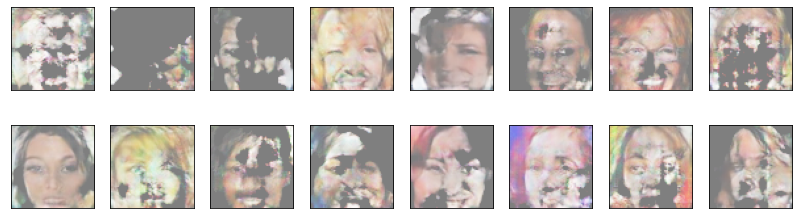

2025-02-28 10:15:24 | Epoch [24/25] | Batch 0/509 | d_loss: 0.6432 | g_loss: 3.6997
2025-02-28 10:15:48 | Epoch [24/25] | Batch 50/509 | d_loss: 0.7516 | g_loss: 3.9689
2025-02-28 10:16:12 | Epoch [24/25] | Batch 100/509 | d_loss: 1.0949 | g_loss: 4.2018
2025-02-28 10:16:36 | Epoch [24/25] | Batch 150/509 | d_loss: 0.7775 | g_loss: 2.2142
2025-02-28 10:16:59 | Epoch [24/25] | Batch 200/509 | d_loss: 1.3819 | g_loss: 4.5098
2025-02-28 10:17:23 | Epoch [24/25] | Batch 250/509 | d_loss: 0.9660 | g_loss: 3.5592
2025-02-28 10:17:47 | Epoch [24/25] | Batch 300/509 | d_loss: 0.6500 | g_loss: 3.6194
2025-02-28 10:18:11 | Epoch [24/25] | Batch 350/509 | d_loss: 1.0728 | g_loss: 1.3661
2025-02-28 10:18:35 | Epoch [24/25] | Batch 400/509 | d_loss: 0.8200 | g_loss: 1.5671
2025-02-28 10:18:58 | Epoch [24/25] | Batch 450/509 | d_loss: 1.1325 | g_loss: 4.2003
2025-02-28 10:19:22 | Epoch [24/25] | Batch 500/509 | d_loss: 0.9770 | g_loss: 1.5255


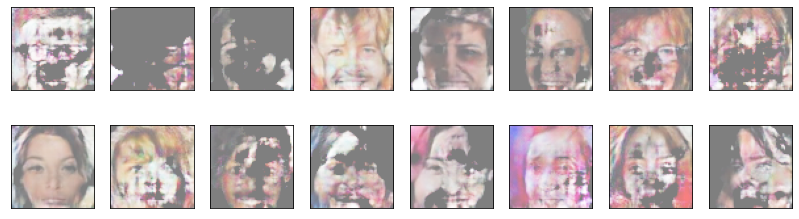

2025-02-28 10:19:30 | Epoch [25/25] | Batch 0/509 | d_loss: 0.7955 | g_loss: 4.3423
2025-02-28 10:19:54 | Epoch [25/25] | Batch 50/509 | d_loss: 0.7559 | g_loss: 4.1958
2025-02-28 10:20:18 | Epoch [25/25] | Batch 100/509 | d_loss: 0.6304 | g_loss: 2.2687
2025-02-28 10:20:42 | Epoch [25/25] | Batch 150/509 | d_loss: 0.8359 | g_loss: 3.3218
2025-02-28 10:21:06 | Epoch [25/25] | Batch 200/509 | d_loss: 0.6662 | g_loss: 3.5503
2025-02-28 10:21:29 | Epoch [25/25] | Batch 250/509 | d_loss: 1.1908 | g_loss: 4.6222
2025-02-28 10:21:53 | Epoch [25/25] | Batch 300/509 | d_loss: 0.9172 | g_loss: 4.0701
2025-02-28 10:22:17 | Epoch [25/25] | Batch 350/509 | d_loss: 1.1781 | g_loss: 1.2043
2025-02-28 10:22:41 | Epoch [25/25] | Batch 400/509 | d_loss: 0.7063 | g_loss: 4.0823
2025-02-28 10:23:05 | Epoch [25/25] | Batch 450/509 | d_loss: 0.6710 | g_loss: 3.4577
2025-02-28 10:23:29 | Epoch [25/25] | Batch 500/509 | d_loss: 0.9356 | g_loss: 3.0204


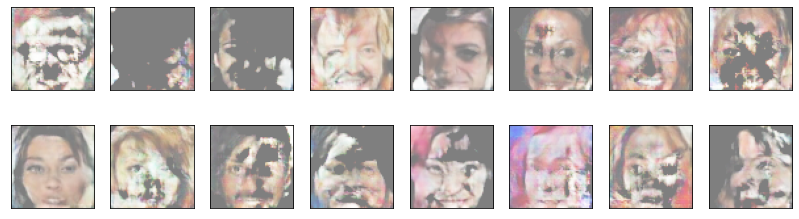

In [24]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        # TODO: implement the training strategy
        batch_size = real_images.size(0)
        
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        g_loss = generator_step(batch_size, latent_dim)
        
        ####################################
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

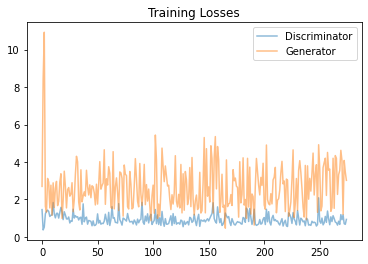

In [25]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (
1) Generated samples are a bit distorted, which is understandable because I have only run it for 25 epochs. But, it already looks good as you could observe the features of the face clearly on the images, which proves that the model is good enough for this GAN. 
2) Yes, from the images, you see a strong bias towards the white faces, as you don't see any other color face generated.
3) One could think of implementing Cycle-GAN architecture which brings the complexity of the model to a different size, thus achieving the higher performance of the model
4) Further hyperparameter optimizations could be carried out, for example, by tuning the lr, beta1 and beta2 to increase the fastness of improving performances and to avoid the local minimas.)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.